# ***1. data preperation***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown https://drive.google.com/uc?id=19IXmtBUwKpxNqsPGLcBNvMDvZqPJcjbq

Downloading...
From (original): https://drive.google.com/uc?id=19IXmtBUwKpxNqsPGLcBNvMDvZqPJcjbq
From (redirected): https://drive.google.com/uc?id=19IXmtBUwKpxNqsPGLcBNvMDvZqPJcjbq&confirm=t&uuid=fe1c121a-4613-450b-8fb2-5577079c24c4
To: /content/D3_Ulcerative-Keratitis.zip
100% 839M/839M [00:12<00:00, 66.5MB/s]


In [ ]:
!unzip -qq /content/D3_Ulcerative-Keratitis.zip

# ***2. data preprocessing***

In [ ]:
# 필요한 패키지를 설치
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import ImageFile
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
from torch.utils.data import random_split

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

# 예시로 seed를 42로 설정
set_seed(42)

In [ ]:
# 데이터 경로 설정
data_path = "/content/D3_Ulcerative-Keratitis"
# 전처리 및 데이터 로드
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조절
    transforms.ToTensor(),           # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 이미지를 정규화
])

dataset = datasets.ImageFolder(root=data_path, transform=transform)

# 비율 설정
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# 데이터셋을 8:1:1 비율로 훈련, 검증, 테스트 세트로 분할
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# 데이터 로더 설정
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 클래스 라벨 가져오기
class_labels = dataset.classes

# 클래스 라벨 출력
print("클래스 라벨:", class_labels)

클래스 라벨: ['Mild', 'Severe', 'negative']


## ***2-1. image visualization***

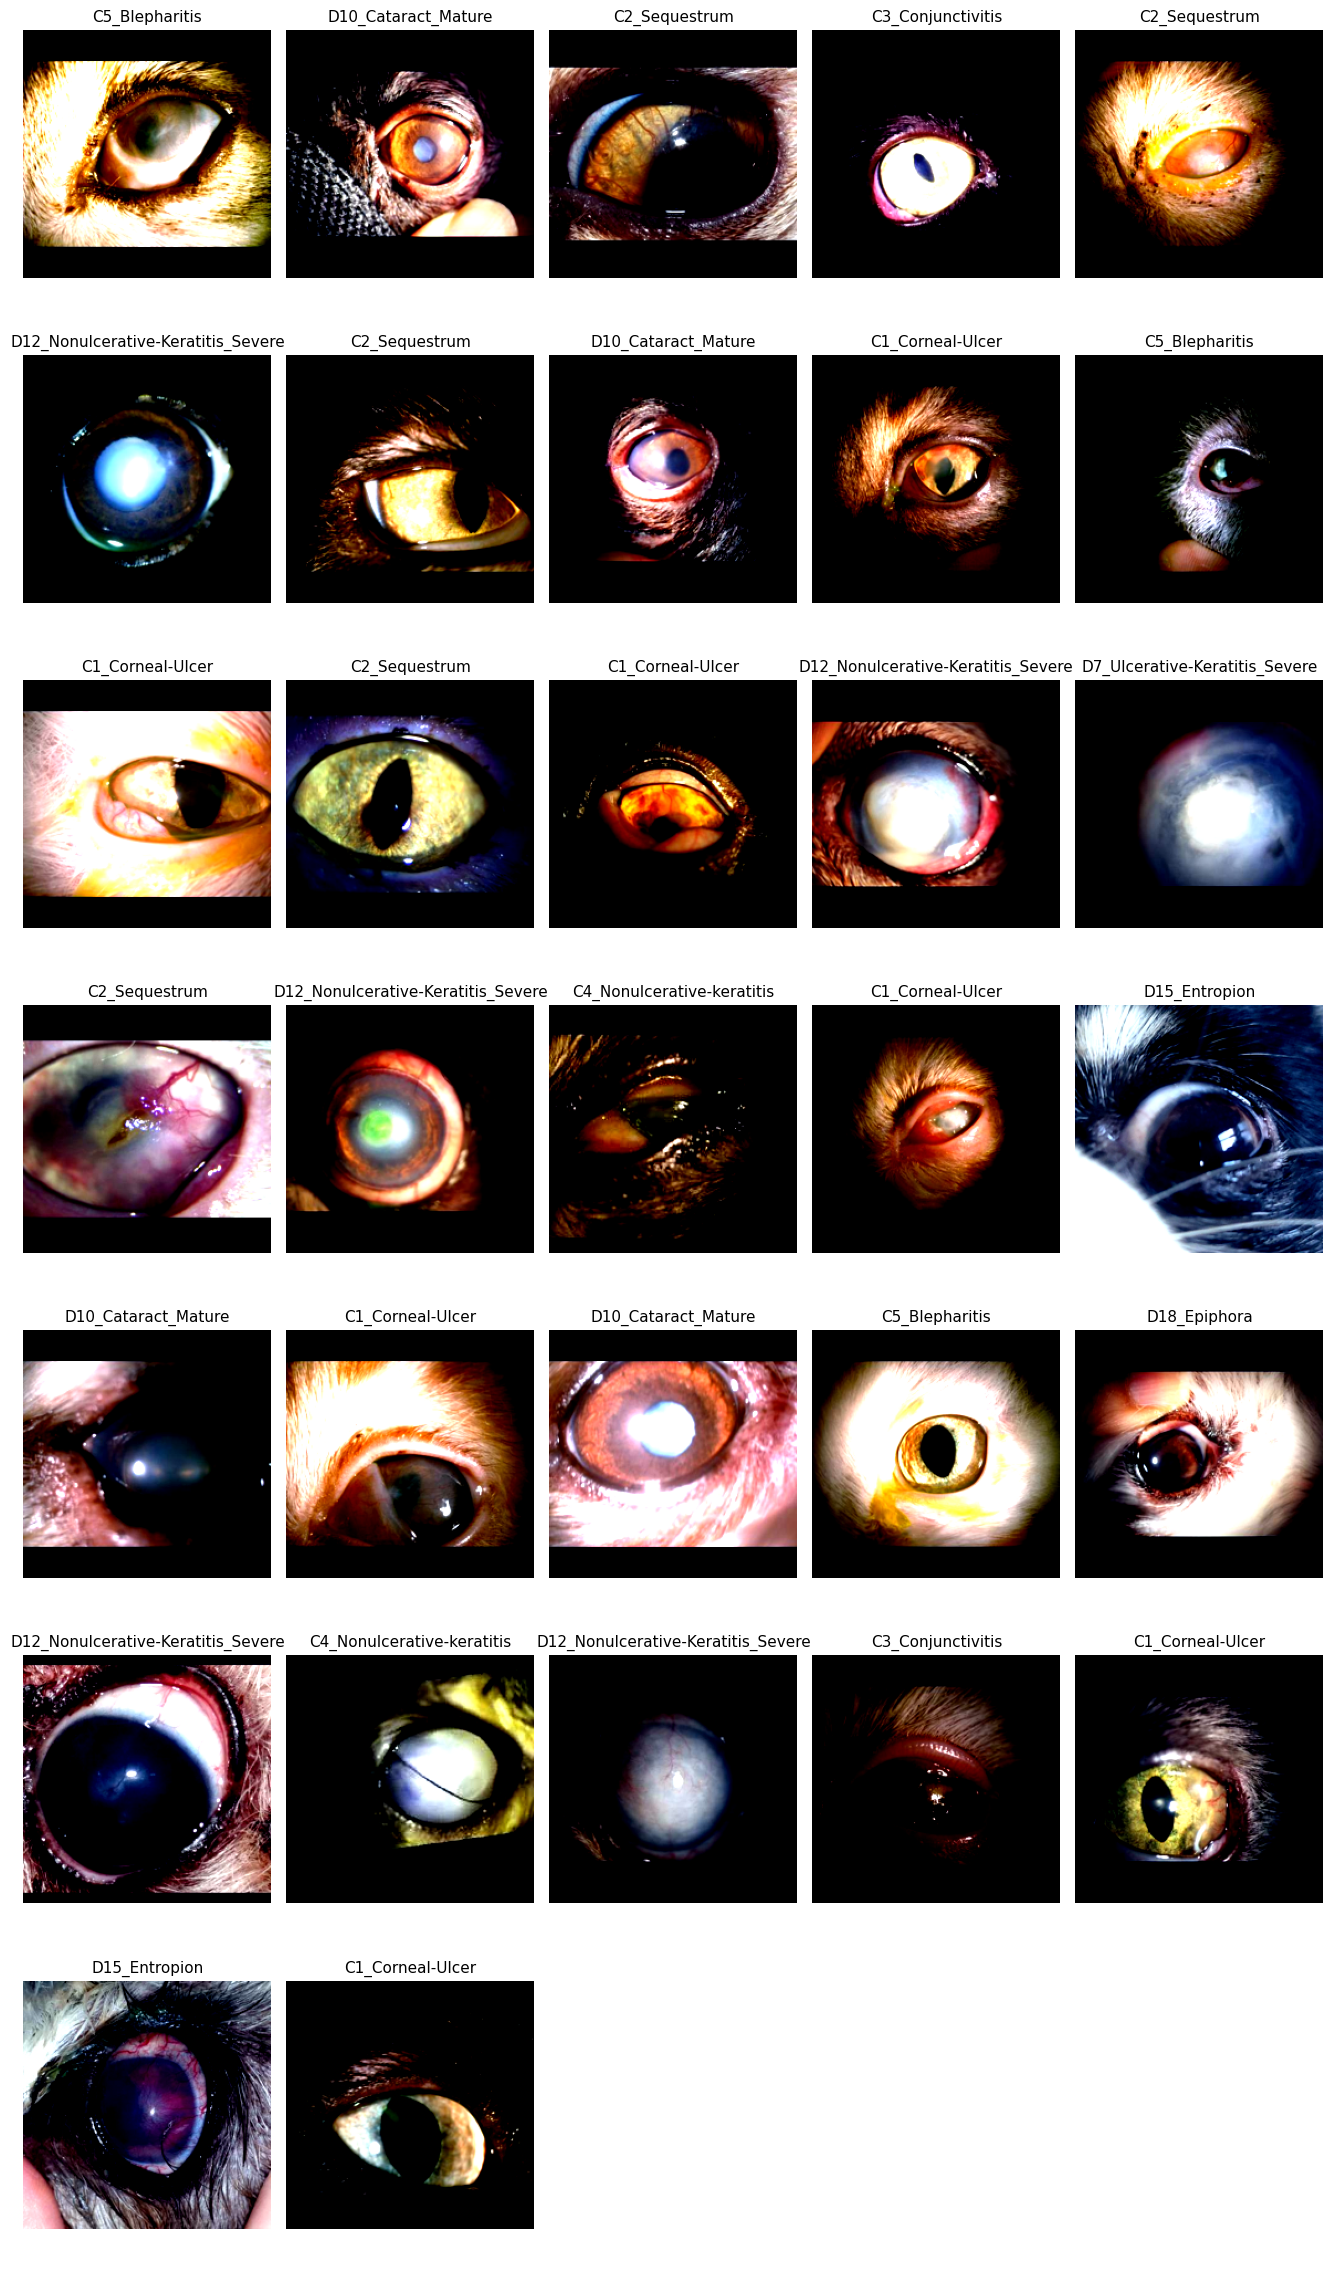

In [ ]:
# 데이터로더에서 이미지와 레이블 가져오기
images, labels = next(iter(train_loader))

# 클래스 인덱스와 클래스명 매핑
class_names = train_dataset.classes

# 이미지 확인을 위한 코드
num_images = len(images)
num_columns = 5  # 한 줄에 표시할 이미지 수

num_rows = (num_images + num_columns - 1) // num_columns  # 필요한 행 수 계산
fig, axs = plt.subplots(num_rows, num_columns, figsize=(13.3, 3.3 * num_rows))  # 플롯의 크기 조정

for i in range(num_images):
    row = i // num_columns  # 현재 이미지의 행
    col = i % num_columns  # 현재 이미지의 열

    image = images[i].permute(1, 2, 0)  # 이미지의 차원을 (H, W, C)로 변경
    image = 0.5 * image + 0.5  # 이미지를 정규화 해제

    axs[row, col].imshow(image)
    axs[row, col].set_title(class_names[labels[i].item()], fontsize=11)  # 클래스명 표시, 폰트 크기 조정 (1포인트 증가)
    axs[row, col].axis('off')

# 남은 공간에 빈 플롯 생성
for i in range(num_images, num_rows * num_columns):
    row = i // num_columns  # 현재 이미지의 행
    col = i % num_columns  # 현재 이미지의 열
    axs[row, col].axis('off')

plt.tight_layout()  # 레이아웃 조정
plt.show()

# ***3. model load & parameter***

In [ ]:
# 사전 훈련된 모델을 로드하고, 출력 레이어를 새로운 분류를 수행할 수 있도록 변경

# 모델 초기화
num_classes = len(dataset.classes)
model = models.resnet50(pretrained=True) # False가 되면 모델의 구조만 가져오고 초깃값은 랜덤 설정

# ResNet 모델의 Fully Connected Layer 변경
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# 드롭아웃 레이어 추가
model.dropout = nn.Dropout(0.5)  # 드롭아웃 확률 조정

# 모델 출력
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# ***4. criterion & optimizer***

In [ ]:
import torch.optim as optim

# 손실 함수 및 Adam 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=0.01)

from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
# Transfer Learning
ct = 0
for child in model.children():  # model.children() -> 모델의 layer정보
  ct += 1
  if ct < 6:
    for param in child.parameters():
      param.requires_grad = False

# ***5. model training***

In [ ]:
# 배치 수 확인
total_batch = len(train_loader)
print(total_batch) # 2824 * 3 / 32 = 264.75

516


In [ ]:
# #colab 상의 No GPU 문제 해결을 위한 cuda 설치
# !apt-get --purge remove cuda nvidia* libnvidia-*
# !dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
# !apt-get remove cuda-*
# !apt autoremove
# !wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
# !sudo dpkg -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
# !sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
# !sudo apt-get update
# !wget http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
# !sudo apt install -y ./nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
# !sudo apt-get update

# # Install NVIDIA driver
# #!sudo apt-get install --no-install-recommends nvidia-driver-418
# !sudo apt-get -y installnvidia-driver-418
# # Reboot. Check that GPUs are visible using the command: nvidia-smi

# # Install development and runtime libraries (~4GB)
# #!sudo apt-get install --no-install-recommends \
# !sudo apt-get install -y \
#     cuda-10-0 \
#     libcudnn7=7.6.2.24-1+cuda10.0  \
#     libcudnn7-dev=7.6.2.24-1+cuda10.0


# # Install TensorRT. Requires that libcudnn7 is installed above.
# # !sudo apt-get install -y --no-install-recommends libnvinfer5=5.1.5-1+cuda10.0 \
# !sudo apt-get install -y libnvinfer5=5.1.5-1+cuda10.0 \
#     libnvinfer-dev=5.1.5-1+cuda10.0

# !apt --fix-broken install

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'nvidia-driver-550-server' for glob 'nvidia*'
Note, selecting 'nvidia-firmware-535-535.154.05' for glob 'nvidia*'
Note, selecting 'nvidia-docker2' for glob 'nvidia*'
Note, selecting 'nvidia-cuda-toolkit-doc' for glob 'nvidia*'
Note, selecting 'nvidia-imex' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-firmware-535-server-535.154.05' for glob 'nvidia*'
Note, selecting 'nvidia-headless-390' for glob 'nvidia*'
Note, selecting 'nvidia-cuda-toolkit-gcc' for glob 'nvidia*'
Note, selecting 'nvidia-headless-418' for glob 'nvidia*'
Note, selecting 'nvidia-headless-430' for glob 'nvidia*'
Note, selecting 'nvidia-headless-435' for glob 'nvidia*'
Note, selecting 'nvidia-headless-440' for glob 'nvidia*'
Note, selecting 'nvidia-headless-450' for glob 'nvidia*'
Note, selecting 'nvidia-headless-455' for glob 'nvidia*'
Note, selecting 

In [ ]:
# 얼리스탑
def early_stopping(val_loss_history, patience=5):
    if len(val_loss_history) < patience + 1:
        return False
    else:
        if all(val_loss_history[-1] >= val_loss_history[-patience-1:]):
            return True
        else:
            return False

# 모델 훈련
def train_model_with_checkpoint(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device='cuda'):
    model.to(device)

    # 훈련 중간 결과 저장할 딕셔너리 초기화
    results = {
        'epoch_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'train_loss': [],
        'train_accuracy': []
    }

    try:
        val_loss_history = []
        for epoch in range(num_epochs):
            epoch_start_time = time.time()  # 에폭 시작 시간 기록

            # Training
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader.dataset)
            train_accuracy = correct / total
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

            # Validation
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            predictions = []
            targets = []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += criterion(outputs, labels).item() * inputs.size(0)
                    predictions.extend(predicted.cpu().numpy())
                    targets.extend(labels.cpu().numpy())

            val_accuracy = correct / total
            val_loss = val_loss / len(val_loader.dataset)
            val_precision = precision_score(targets, predictions, average='weighted')
            val_recall = recall_score(targets, predictions, average='weighted')
            val_f1 = f1_score(targets, predictions, average='weighted')

            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F1 Score: {val_f1:.4f}, Time: {time.time() - epoch_start_time:.0f}s")

            # 중간 결과 저장
            results['epoch_loss'].append(train_loss)
            results['val_loss'].append(val_loss)
            results['val_accuracy'].append(val_accuracy)
            results['val_precision'].append(val_precision)
            results['val_recall'].append(val_recall)
            results['val_f1'].append(val_f1)
            results['train_loss'].append(train_loss)
            results['train_accuracy'].append(train_accuracy)

            # Early Stopping 체크
            if early_stopping(val_loss_history, patience=5):
                print("Early stopping!")
                break
    except Exception as e:
        print(f"An error occurred during training: {str(e)}")

    # best 에폭 찾기
    best_epoch = np.argmax(results['val_accuracy'])
    best_accuracy = results['val_accuracy'][best_epoch]
    print(f"Best Validation Accuracy: {best_accuracy:.4f} at Epoch {best_epoch+1}")

    # 해당 에폭의 모델 저장
    best_model = model
    torch.save(best_model.state_dict(), 'best_model.pth')

    return results, best_model

# 모델 학습
results, best_model = train_model_with_checkpoint(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

Epoch 1/50: 100%|██████████| 516/516 [03:39<00:00,  2.35it/s]


Epoch 1/50, Train Loss: 0.4446, Train Accuracy: 0.8199
Epoch 1/50, Validation Loss: 0.9853, Validation Accuracy: 0.5354, Validation Precision: 0.7211, Validation Recall: 0.5354, Validation F1 Score: 0.4653, Time: 234s


Epoch 2/50: 100%|██████████| 516/516 [03:24<00:00,  2.53it/s]


Epoch 2/50, Train Loss: 0.3649, Train Accuracy: 0.8517
Epoch 2/50, Validation Loss: 0.2937, Validation Accuracy: 0.8986, Validation Precision: 0.9037, Validation Recall: 0.8986, Validation F1 Score: 0.8964, Time: 218s


Epoch 3/50: 100%|██████████| 516/516 [03:22<00:00,  2.55it/s]


Epoch 3/50, Train Loss: 0.3183, Train Accuracy: 0.8742
Epoch 3/50, Validation Loss: 0.2949, Validation Accuracy: 0.8831, Validation Precision: 0.8861, Validation Recall: 0.8831, Validation F1 Score: 0.8826, Time: 216s


Epoch 4/50: 100%|██████████| 516/516 [03:21<00:00,  2.57it/s]


Epoch 4/50, Train Loss: 0.2919, Train Accuracy: 0.8851
Epoch 4/50, Validation Loss: 0.2438, Validation Accuracy: 0.9132, Validation Precision: 0.9144, Validation Recall: 0.9132, Validation F1 Score: 0.9136, Time: 215s


Epoch 5/50: 100%|██████████| 516/516 [03:18<00:00,  2.60it/s]


Epoch 5/50, Train Loss: 0.2842, Train Accuracy: 0.8882
Epoch 5/50, Validation Loss: 0.2480, Validation Accuracy: 0.9064, Validation Precision: 0.9101, Validation Recall: 0.9064, Validation F1 Score: 0.9048, Time: 213s


Epoch 6/50: 100%|██████████| 516/516 [03:18<00:00,  2.60it/s]


Epoch 6/50, Train Loss: 0.2751, Train Accuracy: 0.8914
Epoch 6/50, Validation Loss: 0.2821, Validation Accuracy: 0.8928, Validation Precision: 0.8965, Validation Recall: 0.8928, Validation F1 Score: 0.8925, Time: 212s


Epoch 7/50: 100%|██████████| 516/516 [03:17<00:00,  2.61it/s]


Epoch 7/50, Train Loss: 0.2586, Train Accuracy: 0.8986
Epoch 7/50, Validation Loss: 0.2612, Validation Accuracy: 0.8996, Validation Precision: 0.8984, Validation Recall: 0.8996, Validation F1 Score: 0.8982, Time: 212s


Epoch 8/50: 100%|██████████| 516/516 [03:17<00:00,  2.61it/s]


Epoch 8/50, Train Loss: 0.2487, Train Accuracy: 0.9060
Epoch 8/50, Validation Loss: 0.2293, Validation Accuracy: 0.9137, Validation Precision: 0.9159, Validation Recall: 0.9137, Validation F1 Score: 0.9143, Time: 212s


Epoch 9/50: 100%|██████████| 516/516 [03:16<00:00,  2.62it/s]


Epoch 9/50, Train Loss: 0.2418, Train Accuracy: 0.9076
Epoch 9/50, Validation Loss: 0.3013, Validation Accuracy: 0.8652, Validation Precision: 0.8841, Validation Recall: 0.8652, Validation F1 Score: 0.8581, Time: 211s


Epoch 10/50: 100%|██████████| 516/516 [03:15<00:00,  2.64it/s]


Epoch 10/50, Train Loss: 0.2382, Train Accuracy: 0.9073
Epoch 10/50, Validation Loss: 0.2035, Validation Accuracy: 0.9219, Validation Precision: 0.9252, Validation Recall: 0.9219, Validation F1 Score: 0.9215, Time: 210s


Epoch 11/50: 100%|██████████| 516/516 [03:14<00:00,  2.65it/s]


Epoch 11/50, Train Loss: 0.2357, Train Accuracy: 0.9112
Epoch 11/50, Validation Loss: 0.2351, Validation Accuracy: 0.9064, Validation Precision: 0.9052, Validation Recall: 0.9064, Validation F1 Score: 0.9053, Time: 209s


Epoch 12/50: 100%|██████████| 516/516 [03:15<00:00,  2.64it/s]


Epoch 12/50, Train Loss: 0.2351, Train Accuracy: 0.9102
Epoch 12/50, Validation Loss: 0.2576, Validation Accuracy: 0.9234, Validation Precision: 0.9229, Validation Recall: 0.9234, Validation F1 Score: 0.9229, Time: 209s


Epoch 13/50: 100%|██████████| 516/516 [03:16<00:00,  2.62it/s]


Epoch 13/50, Train Loss: 0.2366, Train Accuracy: 0.9093
Epoch 13/50, Validation Loss: 0.2510, Validation Accuracy: 0.9020, Validation Precision: 0.9080, Validation Recall: 0.9020, Validation F1 Score: 0.9019, Time: 211s


Epoch 14/50: 100%|██████████| 516/516 [03:16<00:00,  2.63it/s]


Epoch 14/50, Train Loss: 0.2276, Train Accuracy: 0.9120
Epoch 14/50, Validation Loss: 0.2215, Validation Accuracy: 0.9113, Validation Precision: 0.9155, Validation Recall: 0.9113, Validation F1 Score: 0.9106, Time: 210s


Epoch 15/50: 100%|██████████| 516/516 [03:15<00:00,  2.64it/s]


Epoch 15/50, Train Loss: 0.2271, Train Accuracy: 0.9129
Epoch 15/50, Validation Loss: 0.1843, Validation Accuracy: 0.9282, Validation Precision: 0.9313, Validation Recall: 0.9282, Validation F1 Score: 0.9275, Time: 210s


Epoch 16/50: 100%|██████████| 516/516 [03:15<00:00,  2.63it/s]


Epoch 16/50, Train Loss: 0.2177, Train Accuracy: 0.9183
Epoch 16/50, Validation Loss: 0.1914, Validation Accuracy: 0.9277, Validation Precision: 0.9291, Validation Recall: 0.9277, Validation F1 Score: 0.9280, Time: 210s


Epoch 17/50: 100%|██████████| 516/516 [03:15<00:00,  2.64it/s]


Epoch 17/50, Train Loss: 0.2227, Train Accuracy: 0.9176
Epoch 17/50, Validation Loss: 0.2314, Validation Accuracy: 0.9074, Validation Precision: 0.9122, Validation Recall: 0.9074, Validation F1 Score: 0.9074, Time: 210s


Epoch 18/50: 100%|██████████| 516/516 [03:15<00:00,  2.63it/s]


Epoch 18/50, Train Loss: 0.2120, Train Accuracy: 0.9228
Epoch 18/50, Validation Loss: 0.2468, Validation Accuracy: 0.8919, Validation Precision: 0.9004, Validation Recall: 0.8919, Validation F1 Score: 0.8872, Time: 210s


Epoch 19/50: 100%|██████████| 516/516 [03:15<00:00,  2.64it/s]


Epoch 19/50, Train Loss: 0.2134, Train Accuracy: 0.9188
Epoch 19/50, Validation Loss: 0.3851, Validation Accuracy: 0.8404, Validation Precision: 0.8529, Validation Recall: 0.8404, Validation F1 Score: 0.8373, Time: 209s


Epoch 20/50: 100%|██████████| 516/516 [03:15<00:00,  2.64it/s]


Epoch 20/50, Train Loss: 0.2151, Train Accuracy: 0.9157
Epoch 20/50, Validation Loss: 0.4856, Validation Accuracy: 0.8050, Validation Precision: 0.8382, Validation Recall: 0.8050, Validation F1 Score: 0.7958, Time: 210s


Epoch 21/50: 100%|██████████| 516/516 [03:15<00:00,  2.64it/s]


Epoch 21/50, Train Loss: 0.2135, Train Accuracy: 0.9188
Epoch 21/50, Validation Loss: 0.3294, Validation Accuracy: 0.8715, Validation Precision: 0.8988, Validation Recall: 0.8715, Validation F1 Score: 0.8726, Time: 209s


Epoch 22/50: 100%|██████████| 516/516 [03:17<00:00,  2.61it/s]


Epoch 22/50, Train Loss: 0.2102, Train Accuracy: 0.9194
Epoch 22/50, Validation Loss: 0.2364, Validation Accuracy: 0.9045, Validation Precision: 0.9143, Validation Recall: 0.9045, Validation F1 Score: 0.9039, Time: 212s


Epoch 23/50: 100%|██████████| 516/516 [03:17<00:00,  2.61it/s]


Epoch 23/50, Train Loss: 0.2091, Train Accuracy: 0.9211
Epoch 23/50, Validation Loss: 0.2261, Validation Accuracy: 0.9132, Validation Precision: 0.9167, Validation Recall: 0.9132, Validation F1 Score: 0.9141, Time: 212s


Epoch 24/50: 100%|██████████| 516/516 [03:16<00:00,  2.62it/s]


Epoch 24/50, Train Loss: 0.2107, Train Accuracy: 0.9203
Epoch 24/50, Validation Loss: 0.3109, Validation Accuracy: 0.8710, Validation Precision: 0.8866, Validation Recall: 0.8710, Validation F1 Score: 0.8629, Time: 211s


Epoch 25/50: 100%|██████████| 516/516 [03:16<00:00,  2.63it/s]


Epoch 25/50, Train Loss: 0.2144, Train Accuracy: 0.9188
Epoch 25/50, Validation Loss: 0.1908, Validation Accuracy: 0.9214, Validation Precision: 0.9210, Validation Recall: 0.9214, Validation F1 Score: 0.9208, Time: 211s


Epoch 26/50: 100%|██████████| 516/516 [03:16<00:00,  2.62it/s]


Epoch 26/50, Train Loss: 0.2094, Train Accuracy: 0.9219
Epoch 26/50, Validation Loss: 1.2324, Validation Accuracy: 0.5926, Validation Precision: 0.7944, Validation Recall: 0.5926, Validation F1 Score: 0.5364, Time: 211s


Epoch 27/50: 100%|██████████| 516/516 [03:16<00:00,  2.63it/s]


Epoch 27/50, Train Loss: 0.2101, Train Accuracy: 0.9231
Epoch 27/50, Validation Loss: 0.2498, Validation Accuracy: 0.9011, Validation Precision: 0.9140, Validation Recall: 0.9011, Validation F1 Score: 0.9003, Time: 211s


Epoch 28/50: 100%|██████████| 516/516 [03:17<00:00,  2.62it/s]


Epoch 28/50, Train Loss: 0.2052, Train Accuracy: 0.9223
Epoch 28/50, Validation Loss: 0.2231, Validation Accuracy: 0.9113, Validation Precision: 0.9150, Validation Recall: 0.9113, Validation F1 Score: 0.9119, Time: 211s


Epoch 29/50: 100%|██████████| 516/516 [03:17<00:00,  2.62it/s]


Epoch 29/50, Train Loss: 0.2092, Train Accuracy: 0.9206
Epoch 29/50, Validation Loss: 0.3721, Validation Accuracy: 0.8351, Validation Precision: 0.8770, Validation Recall: 0.8351, Validation F1 Score: 0.8290, Time: 211s


Epoch 30/50: 100%|██████████| 516/516 [03:16<00:00,  2.62it/s]


Epoch 30/50, Train Loss: 0.2071, Train Accuracy: 0.9193
Epoch 30/50, Validation Loss: 0.1752, Validation Accuracy: 0.9326, Validation Precision: 0.9323, Validation Recall: 0.9326, Validation F1 Score: 0.9324, Time: 211s


Epoch 31/50: 100%|██████████| 516/516 [03:17<00:00,  2.61it/s]


Epoch 31/50, Train Loss: 0.2084, Train Accuracy: 0.9203
Epoch 31/50, Validation Loss: 0.3522, Validation Accuracy: 0.8545, Validation Precision: 0.8599, Validation Recall: 0.8545, Validation F1 Score: 0.8494, Time: 212s


Epoch 32/50: 100%|██████████| 516/516 [03:16<00:00,  2.62it/s]


Epoch 32/50, Train Loss: 0.2058, Train Accuracy: 0.9235
Epoch 32/50, Validation Loss: 0.3050, Validation Accuracy: 0.8729, Validation Precision: 0.9002, Validation Recall: 0.8729, Validation F1 Score: 0.8724, Time: 211s


Epoch 33/50: 100%|██████████| 516/516 [03:16<00:00,  2.63it/s]


Epoch 33/50, Train Loss: 0.2071, Train Accuracy: 0.9223
Epoch 33/50, Validation Loss: 0.2558, Validation Accuracy: 0.8986, Validation Precision: 0.9059, Validation Recall: 0.8986, Validation F1 Score: 0.8981, Time: 210s


Epoch 34/50: 100%|██████████| 516/516 [03:16<00:00,  2.63it/s]


Epoch 34/50, Train Loss: 0.2048, Train Accuracy: 0.9228
Epoch 34/50, Validation Loss: 0.1896, Validation Accuracy: 0.9190, Validation Precision: 0.9253, Validation Recall: 0.9190, Validation F1 Score: 0.9176, Time: 210s


Epoch 35/50: 100%|██████████| 516/516 [03:16<00:00,  2.63it/s]


Epoch 35/50, Train Loss: 0.2035, Train Accuracy: 0.9220
Epoch 35/50, Validation Loss: 0.1904, Validation Accuracy: 0.9224, Validation Precision: 0.9267, Validation Recall: 0.9224, Validation F1 Score: 0.9217, Time: 210s


Epoch 36/50: 100%|██████████| 516/516 [03:16<00:00,  2.63it/s]


Epoch 36/50, Train Loss: 0.2015, Train Accuracy: 0.9253
Epoch 36/50, Validation Loss: 0.1869, Validation Accuracy: 0.9253, Validation Precision: 0.9263, Validation Recall: 0.9253, Validation F1 Score: 0.9254, Time: 210s


Epoch 37/50: 100%|██████████| 516/516 [03:16<00:00,  2.63it/s]


Epoch 37/50, Train Loss: 0.2048, Train Accuracy: 0.9238
Epoch 37/50, Validation Loss: 0.1917, Validation Accuracy: 0.9239, Validation Precision: 0.9265, Validation Recall: 0.9239, Validation F1 Score: 0.9234, Time: 210s


Epoch 38/50: 100%|██████████| 516/516 [03:16<00:00,  2.62it/s]


Epoch 38/50, Train Loss: 0.2052, Train Accuracy: 0.9228
Epoch 38/50, Validation Loss: 0.2236, Validation Accuracy: 0.9059, Validation Precision: 0.9062, Validation Recall: 0.9059, Validation F1 Score: 0.9055, Time: 211s


Epoch 39/50: 100%|██████████| 516/516 [03:17<00:00,  2.61it/s]


Epoch 39/50, Train Loss: 0.1996, Train Accuracy: 0.9259
Epoch 39/50, Validation Loss: 0.2129, Validation Accuracy: 0.9205, Validation Precision: 0.9249, Validation Recall: 0.9205, Validation F1 Score: 0.9209, Time: 212s


Epoch 40/50: 100%|██████████| 516/516 [03:17<00:00,  2.61it/s]


Epoch 40/50, Train Loss: 0.2012, Train Accuracy: 0.9243
Epoch 40/50, Validation Loss: 0.2121, Validation Accuracy: 0.9287, Validation Precision: 0.9327, Validation Recall: 0.9287, Validation F1 Score: 0.9288, Time: 212s


Epoch 41/50: 100%|██████████| 516/516 [03:20<00:00,  2.58it/s]


Epoch 41/50, Train Loss: 0.1987, Train Accuracy: 0.9257
Epoch 41/50, Validation Loss: 0.2898, Validation Accuracy: 0.8754, Validation Precision: 0.8976, Validation Recall: 0.8754, Validation F1 Score: 0.8741, Time: 215s


Epoch 42/50: 100%|██████████| 516/516 [03:19<00:00,  2.59it/s]


Epoch 42/50, Train Loss: 0.1980, Train Accuracy: 0.9243
Epoch 42/50, Validation Loss: 0.2292, Validation Accuracy: 0.9108, Validation Precision: 0.9180, Validation Recall: 0.9108, Validation F1 Score: 0.9112, Time: 214s


Epoch 43/50: 100%|██████████| 516/516 [03:19<00:00,  2.59it/s]


Epoch 43/50, Train Loss: 0.1951, Train Accuracy: 0.9282
Epoch 43/50, Validation Loss: 0.4870, Validation Accuracy: 0.8118, Validation Precision: 0.8710, Validation Recall: 0.8118, Validation F1 Score: 0.8040, Time: 214s


Epoch 44/50: 100%|██████████| 516/516 [03:18<00:00,  2.60it/s]


Epoch 44/50, Train Loss: 0.2015, Train Accuracy: 0.9262
Epoch 44/50, Validation Loss: 0.2437, Validation Accuracy: 0.8996, Validation Precision: 0.9038, Validation Recall: 0.8996, Validation F1 Score: 0.8960, Time: 212s


Epoch 45/50: 100%|██████████| 516/516 [03:17<00:00,  2.61it/s]


Epoch 45/50, Train Loss: 0.1957, Train Accuracy: 0.9282
Epoch 45/50, Validation Loss: 0.2090, Validation Accuracy: 0.9195, Validation Precision: 0.9208, Validation Recall: 0.9195, Validation F1 Score: 0.9187, Time: 212s


Epoch 46/50: 100%|██████████| 516/516 [03:16<00:00,  2.62it/s]


Epoch 46/50, Train Loss: 0.2027, Train Accuracy: 0.9229
Epoch 46/50, Validation Loss: 0.2013, Validation Accuracy: 0.9185, Validation Precision: 0.9234, Validation Recall: 0.9185, Validation F1 Score: 0.9179, Time: 211s


Epoch 47/50: 100%|██████████| 516/516 [03:17<00:00,  2.61it/s]


Epoch 47/50, Train Loss: 0.1951, Train Accuracy: 0.9274
Epoch 47/50, Validation Loss: 0.2385, Validation Accuracy: 0.9064, Validation Precision: 0.9138, Validation Recall: 0.9064, Validation F1 Score: 0.9054, Time: 212s


Epoch 48/50: 100%|██████████| 516/516 [03:16<00:00,  2.62it/s]


Epoch 48/50, Train Loss: 0.1980, Train Accuracy: 0.9270
Epoch 48/50, Validation Loss: 0.5125, Validation Accuracy: 0.8143, Validation Precision: 0.8696, Validation Recall: 0.8143, Validation F1 Score: 0.8158, Time: 211s


Epoch 49/50: 100%|██████████| 516/516 [03:17<00:00,  2.61it/s]


Epoch 49/50, Train Loss: 0.2004, Train Accuracy: 0.9237
Epoch 49/50, Validation Loss: 0.2205, Validation Accuracy: 0.9137, Validation Precision: 0.9187, Validation Recall: 0.9137, Validation F1 Score: 0.9145, Time: 212s


Epoch 50/50: 100%|██████████| 516/516 [03:17<00:00,  2.61it/s]


Epoch 50/50, Train Loss: 0.2000, Train Accuracy: 0.9245
Epoch 50/50, Validation Loss: 0.2143, Validation Accuracy: 0.9171, Validation Precision: 0.9177, Validation Recall: 0.9171, Validation F1 Score: 0.9158, Time: 212s
Best Validation Accuracy: 0.9326 at Epoch 30


# ***6. model save***

In [ ]:
# 모델 자체를 저장

PATH = '/content/drive/MyDrive/D3_resnet50.pth'
torch.save(model, PATH) # 해당 path에 모델을 저장

## ***5-2. loss visualization***

In [ ]:
import pandas as pd

# 훈련 결과를 DataFrame으로 변환
results_df = pd.DataFrame({
    'Epoch': range(1, len(results['epoch_loss']) + 1),
    'Train Loss': results['train_loss'],
    'Train Accuracy': results['train_accuracy'],
    'Validation Loss': results['val_loss'],
    'Validation Accuracy': results['val_accuracy'],
    'Validation Precision': results['val_precision'],
    'Validation Recall': results['val_recall'],
    'Validation F1 Score': results['val_f1']
})

# DataFrame 출력
print(results_df)

    Epoch  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy  \
0       1    0.444643        0.819896         0.985335             0.535403   
1       2    0.364931        0.851661         0.293697             0.898642   
2       3    0.318336        0.874212         0.294894             0.883123   
3       4    0.291864        0.885124         0.243784             0.913191   
4       5    0.284197        0.888155         0.247995             0.906402   
5       6    0.275087        0.891368         0.282077             0.892823   
6       7    0.258581        0.898581         0.261235             0.899612   
7       8    0.248662        0.905977         0.229277             0.913676   
8       9    0.241766        0.907553         0.301320             0.865179   
9      10    0.238236        0.907311         0.203470             0.921920   
10     11    0.235691        0.911191         0.235061             0.906402   
11     12    0.235091        0.910221         0.2575

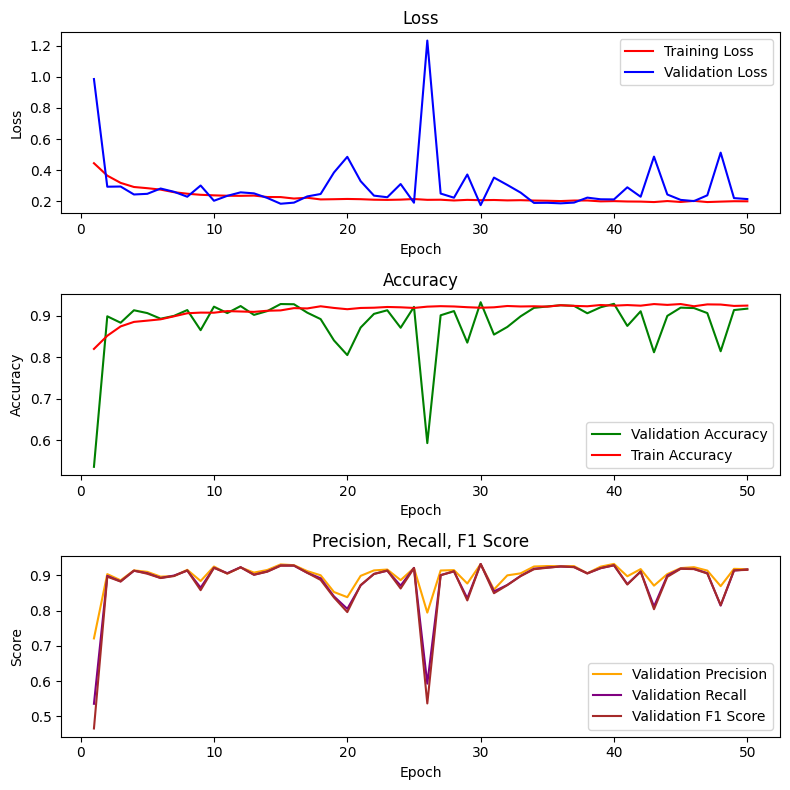

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(results):
    num_epochs = len(results['epoch_loss'])
    epochs = range(1, num_epochs + 1)

    # Loss 그래프
    fig, axes = plt.subplots(3, 1, figsize=(8, 8))

    axes[0].plot(epochs, results['epoch_loss'], label='Training Loss', color='red')
    axes[0].plot(epochs, results['val_loss'], label='Validation Loss', color='blue')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy 그래프
    axes[1].plot(epochs, results['val_accuracy'], label='Validation Accuracy', color='green')
    axes[1].plot(epochs, results['train_accuracy'], label='Train Accuracy', color='red')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Precision, Recall, F1 Score 그래프
    axes[2].plot(epochs, results['val_precision'], label='Validation Precision', color='orange')
    axes[2].plot(epochs, results['val_recall'], label='Validation Recall', color='purple')
    axes[2].plot(epochs, results['val_f1'], label='Validation F1 Score', color='brown')
    axes[2].set_title('Precision, Recall, F1 Score')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Score')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# 학습 결과 시각화
plot_training_history(results)


# ***7. model test***

In [ ]:
# best 모델 불러오기
best_model = models.resnet50(pretrained=False, num_classes=num_classes)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.to(device)
best_model.eval()

# 테스트 데이터셋으로 평가
correct = 0
total = 0
predictions = []
targets = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Accuracy: 0.9176


# ***8. confusion matrix***

<Figure size 1500x1000 with 0 Axes>

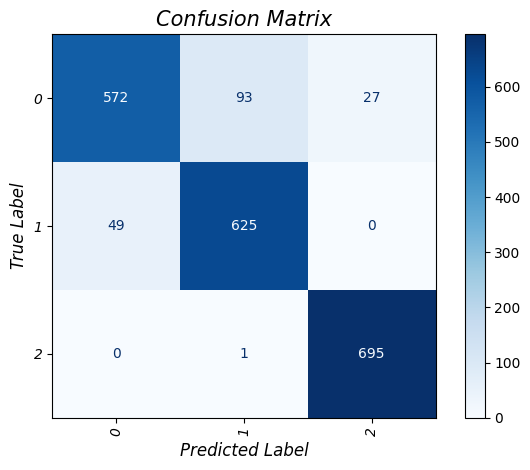

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 혼동 행렬 생성
conf_matrix = confusion_matrix(targets, predictions)

# 혼동 행렬 출력
plt.figure(figsize=(15, 10))
cmd = ConfusionMatrixDisplay(conf_matrix)
cmd.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')  # x축 레이블 회전
plt.xlabel('Predicted Label', fontsize=12, fontstyle='italic')  # 예측 레이블 폰트 기울임
plt.ylabel('True Label', fontsize=12, fontstyle='italic')  # 실제 레이블 폰트 기울임
plt.title('Confusion Matrix', fontsize=15, fontstyle='italic')  # 제목 폰트 기울임
plt.xticks(fontsize=10, fontstyle='italic')  # x축 눈금 폰트 크기 및 기울임 조정
plt.yticks(fontsize=10, fontstyle='italic')  # y축 눈금 폰트 크기 및 기울임 조정
plt.tight_layout()
plt.show()